In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

In [12]:
# Define paths to your train and test data folders
train_data_dir = 'fer2013/train'
test_data_dir = 'fer2013/test'

In [13]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
# Generate batches of augmented data for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
# Modify the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),#slide over the input inage
    MaxPooling2D((2, 2)),#reduce sizeof image
    Dropout(0.25),  # Add dropout to prevent overfitting
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout
    Flatten(),#changes 2d into 1d array
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout
    Dense(7, activation='softmax')
])

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 400s 439ms/step - accuracy: 0.2491 - loss: 1.8188 - val_accuracy: 0.3747 - val_loss: 1.6468
Epoch 2/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 138us/step - accuracy: 0.4688 - loss: 1.4900 - val_accuracy: 0.2000 - val_loss: 1.5305
Epoch 3/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 214s 237ms/step - accuracy: 0.3374 - loss: 1.6782 - val_accuracy: 0.4184 - val_loss: 1.5072
Epoch 4/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 43us/step - accuracy: 0.5000 - loss: 1.6890 - val_accuracy: 0.6000 - val_loss: 1.4496
Epoch 5/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.3808 - loss: 1.5849 - val_accuracy: 0.4629 - val_loss: 1.3997
Epoch 6/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.5000 - loss: 1.4215 - val_accuracy: 0.3000 - val_loss: 1.5518
Epoch 7/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 65s 72ms/step - accuracy: 0.4187 - loss: 1.5009 - val_accuracy: 0.4969 - val_loss: 1.3338
Epoch 8/20
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.5312 - loss: 1.2615 -

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print(f'Test accuracy: {test_acc}')


225/225 - 7s - 31ms/step - accuracy: 0.5318 - loss: 1.2114
Test accuracy: 0.5317637324333191


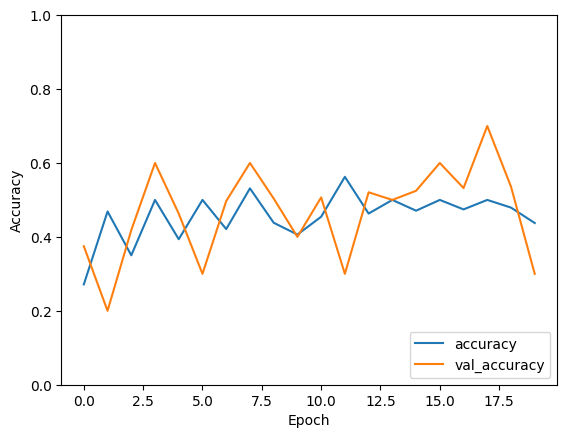

In [17]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [18]:
# Save the trained model
model.save('emotion_detection_model.h5')

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model('emotion_detection_model.h5')

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Initialize the video capture
cap = cv2.VideoCapture(0)  # Use 0 for primary camera, or use a video file path

# Real-time prediction loop
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Preprocess the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    x = image.img_to_array(resized)
    x = np.expand_dims(x, axis=0)
    x /= 255.0  # Rescale to [0, 1]

    # Make prediction
    pred = model.predict(x)
    emotion = emotion_labels[np.argmax(pred)]

    # Display the emotion prediction on the frame
    cv2.putText(frame, emotion, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame
    cv2.imshow('Emotion Detection', frame)

    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━